In [1]:
import sys, random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

### Loading the Dataset as Pandas Dataframe

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

x_train, y_train, x_test, y_test = train_set.iloc[:,:-1],train_set.iloc[:,-1],test_set.iloc[:,:-1],test_set.iloc[:,-1]

### Define an Artificial Neural Network

In [35]:
class ANN():
    # We are going to be building our ANN as a Python class
    def __init__(self, perceptron, activation, dropout, regularizer):

        # Initializing the neural network in the main constructor
        self.model = tf.keras.models.Sequential()

        for i, perceptron in enumerate(perceptron):
            if i == 0:
                self.model.add(tf.keras.layers.Dense(perceptron, activation = activation))
            else:
                self.model.add(tf.keras.layers.Dense(perceptron, activation = activation, kernel_regularizer = tf.keras.regularizers.l2(regularizer)))
                self.model.add(tf.keras.layers.Dropout(dropout))

        self.model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

    # Compiling the model    
    def compile(self, optim, loss, metric):
        self.model.compile(optimizer=optim, loss=loss, metrics=metric)

    # Fitting the model
    def fit(self, x_train, y_train, epochs = 30, batch_size = 32, validation_split = 0.2, verbose = 1):
        self.model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split, verbose = verbose)
    
    # Running an inference on the model
    def inference(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)
    
    # Plotting the loss and accuracy
    def plot_loss_accuracy(self):

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Model performance')
        ax1.plot(self.model.history.history['accuracy'])  
        ax1.plot(self.model.history.history['val_accuracy'])  
        ax2.plot(self.model.history.history['loss'])  
        ax2.plot(self.model.history.history['val_loss'])  
        ax1.set_title('model accuracy')
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        ax1.legend(['train','val'], loc='lower right')
        ax2.set_title('model loss')
        ax2.set_ylabel('loss')
        ax2.set_xlabel('epoch')
        ax2.legend(['train','val'], loc='upper right')

    def predict(self, x_test):
        return self.model.predict(x_test)

Epoch 1/30
750/750 [==============================] - 3s 3ms/step - loss: 1.9835 - accuracy: 0.4470 - val_loss: 1.3129 - val_accuracy: 0.5847
Epoch 2/30
750/750 [==============================] - 2s 2ms/step - loss: 1.2787 - accuracy: 0.6135 - val_loss: 1.0407 - val_accuracy: 0.7112
Epoch 3/30
750/750 [==============================] - 2s 2ms/step - loss: 1.0812 - accuracy: 0.6990 - val_loss: 0.8971 - val_accuracy: 0.7657
Epoch 4/30
750/750 [==============================] - 2s 2ms/step - loss: 0.9628 - accuracy: 0.7423 - val_loss: 0.8043 - val_accuracy: 0.8017
Epoch 5/30
750/750 [==============================] - 2s 2ms/step - loss: 0.8842 - accuracy: 0.7695 - val_loss: 0.7533 - val_accuracy: 0.8078
Epoch 6/30
750/750 [==============================] - 2s 2ms/step - loss: 0.8247 - accuracy: 0.7850 - val_loss: 0.7135 - val_accuracy: 0.8205
Epoch 7/30
750/750 [==============================] - 2s 2ms/step - loss: 0.7800 - accuracy: 0.7994 - val_loss: 0.6818 - val_accuracy: 0.8275
Epoch 

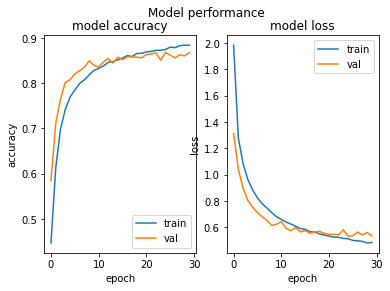

In [36]:
NN = ANN([100,50], 'relu', dropout = 0.4, regularizer = 0.05)
NN.compile('adam','sparse_categorical_crossentropy',['accuracy'])
NN.fit(x_train, y_train,epochs = 30)

NN.plot_loss_accuracy()
print('Inference: ', NN.inference(x_test,y_test))

### Define the Ensemble for the Neural Networks

In [44]:
class ensemble():
    # Initializing constructor with an empty list to hold the models
    def __init__(self):
        self.models = []

        
    # Creating the models for the ensemble
    def build_model(self, no_of_models):
        
        optimizers = ['adam','rmsprop','sgd','adagrad']
        optimizer = random.choice(optimizers)

        for i in range(no_of_models):
            neural_networks = [random.randint(100,150), random.randint(50,100)]
            dropout_rate = random.random()/50
            regularizer_rate = random.random()/10
            
            NN = ANN(neural_networks, activation='relu', dropout=dropout_rate, regularizer=regularizer_rate)
            NN.compile(optimizer,'sparse_categorical_crossentropy',['accuracy'])
            
            self.models.append(NN)

    # Calculate the mean
    def mean_val(self, numerator, denominator):
        return sum(numerator) / len(denominator)
    
    # Fit every model in the ensemble
    def fit(self, x_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1):
        counter = 1
        for model in self.models:
            model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
            print('----------------------------------' + 'Model ' + str(counter) + ' training complete. -------------------------')
            counter += 1

    
    # Inference every model in the ensemble
    def predict(self, x_test):
        result = np.zeros([x_test.shape[0],10])

        for model in self.models:
            result = np.add(result, model.predict(x_test))

        return np.round(result/len(self.models),decimals=2)
    
    # Evaluate the performance of the ensemble
    def eval(self,x_test, y_test):
        loss_list = []
        accuracy_list = []

        for model in self.models:
            loss, acc = model.inference(x_test, y_test)
            loss_list.append(float(loss))
            accuracy_list.append(float(acc))

        print('Average Model Accuracy: %.3f' %  float(self.mean_val(accuracy_list, accuracy_list)))
        print('Average Model Loss: %.3f' %  float(self.mean_val(loss_list, loss_list)))
    
    def plot(self):
        for model in self.models:
            model.plot_loss_accuracy()


In [45]:
def get_labels(y):
    res = []
    for i in range(y.shape[0]):
        res.append(np.argmax(y[i]))
    return res

# Building an ensemble model, that is a combiation of 5 models
ens = ensemble()
ens.build_model(10)

In [46]:
ens.fit(x_train,y_train,15)

Epoch 1/15
750/750 [==============================] - 3s 3ms/step - loss: 1.8440 - accuracy: 0.5572 - val_loss: 1.1805 - val_accuracy: 0.6635
Epoch 2/15
750/750 [==============================] - 2s 2ms/step - loss: 1.0502 - accuracy: 0.7169 - val_loss: 0.8977 - val_accuracy: 0.7772
Epoch 3/15
750/750 [==============================] - 2s 2ms/step - loss: 0.8658 - accuracy: 0.7746 - val_loss: 0.7813 - val_accuracy: 0.8108
Epoch 4/15
750/750 [==============================] - 2s 2ms/step - loss: 0.7590 - accuracy: 0.8064 - val_loss: 0.7252 - val_accuracy: 0.8195
Epoch 5/15
750/750 [==============================] - 2s 2ms/step - loss: 0.6897 - accuracy: 0.8266 - val_loss: 0.7220 - val_accuracy: 0.8077
Epoch 6/15
750/750 [==============================] - 2s 2ms/step - loss: 0.6379 - accuracy: 0.8378 - val_loss: 0.6872 - val_accuracy: 0.8262
Epoch 7/15
750/750 [==============================] - 2s 2ms/step - loss: 0.6036 - accuracy: 0.8486 - val_loss: 0.6262 - val_accuracy: 0.8450
Epoch 

### Evaluate Ensemble Performance

In [47]:
ens.eval(x_test,y_test)

313/313 [==============================] - 0s 1ms/step - loss: 1.0318 - accuracy: 0.7474
Average Model Accuracy: 0.745
Average Model Loss: 1.005


In [49]:
# Print out a confusion Metrix
answers = ens.predict(x_test)
results = get_labels(answers)
confusion_matrix(y_test, results)

array([[ 899,    0,    5,   10,    1,    2,   16,    2,    8,   20],
       [   1, 1093,   11,    3,   25,    1,    0,    3,    3,    0],
       [  20,    6,  733,   22,  100,    7,    6,   67,   27,    7],
       [  13,    4,   32,  772,   10,   46,   33,   13,   62,   23],
       [   2,    4,   84,    1,  748,   28,   14,   64,    5,   33],
       [  13,    4,    4,   31,   42,  736,   37,   10,    4,   14],
       [   7,    8,    3,   21,   27,   45,  724,   28,    2,  135],
       [   4,   13,   69,    8,  126,    5,   44,  705,    5,   39],
       [   5,    9,   53,  133,   51,   20,   16,    5,  683,   10],
       [  20,    1,   12,   12,   70,   24,  118,   35,   12,  709]])

In [51]:
# Calculating the precision, recall and f1 score

precision = precision_score(y_test, results, average='macro')
recall = recall_score(y_test, results, average='macro')
f1 = f1_score(y_test, results,average='macro') 

print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score:', f1)

Precision:  0.7823040217515055
Recall:  0.778798833931418
F1 score: 0.77897298738395


In [52]:
# Output ensemble result

print(classification_report(y_test, results))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       963
           1       0.96      0.96      0.96      1140
           2       0.73      0.74      0.73       995
           3       0.76      0.77      0.76      1008
           4       0.62      0.76      0.69       983
           5       0.81      0.82      0.81       895
           6       0.72      0.72      0.72      1000
           7       0.76      0.69      0.72      1018
           8       0.84      0.69      0.76       985
           9       0.72      0.70      0.71      1013

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

